In [34]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

In [34]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

In [34]:
!unzip /content/sports-balls-multiclass-image-classification.zip -d /content/

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling

import tensorflow as tf
import os


# For reproducibility
import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

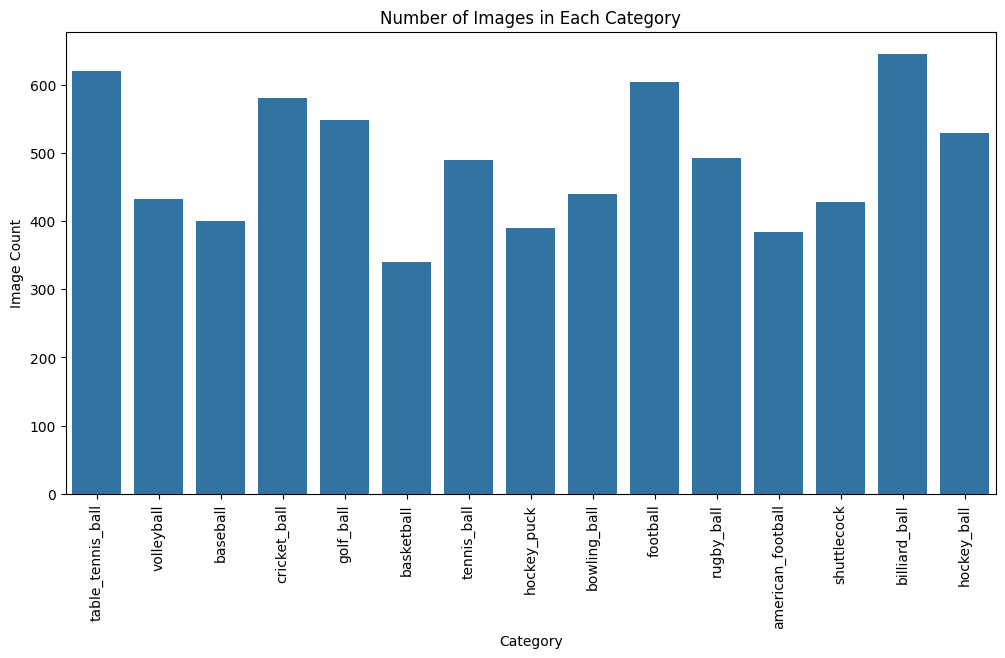

In [36]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Directory path (update with the correct path to your 'train' directory)
train_dir = '/content/train'

# Dictionary to store subdirectory names and file counts
data = {'Category': [], 'Image Count': []}

# Loop through each subdirectory
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        # Count the number of files (images) in the subdirectory
        num_files = len([f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])
        data['Category'].append(sub_dir)
        data['Image Count'].append(num_files)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Image Count', data=df)
plt.xticks(rotation=90)
plt.title('Number of Images in Each Category')
plt.ylabel('Image Count')
plt.xlabel('Category')
plt.show()

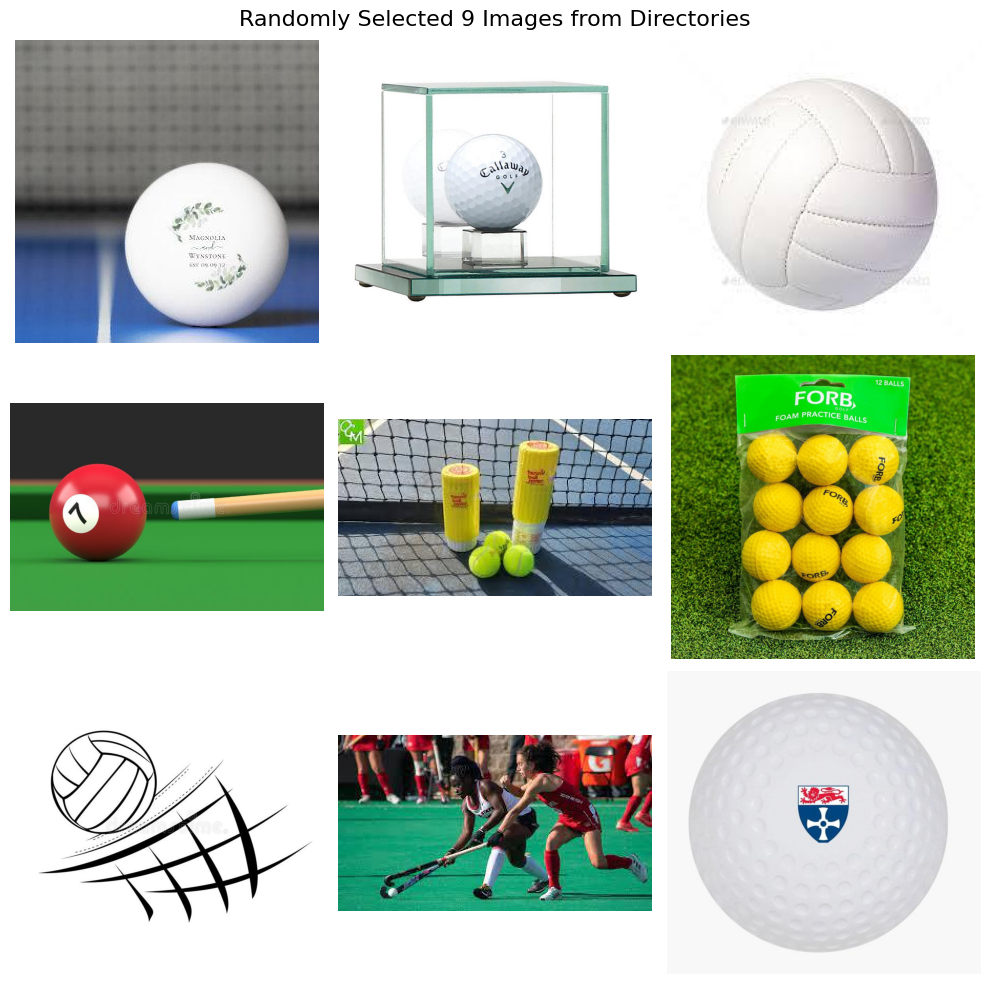

In [37]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory path (update with the correct path to your 'train' directory)
train_dir = '/content/train'

# Get all subdirectories and files in the directories
all_images = []
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        all_images.extend([os.path.join(sub_dir_path, f) for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])

# Randomly select 9 images
random_images = random.sample(all_images, 9)

# Plotting the images in a 3x3 grid
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis

plt.suptitle('Randomly Selected 9 Images from Directories', fontsize=16)
plt.tight_layout()
plt.show()


## **Inception Models from scratch.**

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Inception module as defined in the paper
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # Max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate filters from all branches
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

In [39]:
# Auxiliary classifier for training (deep supervision)
def auxiliary_classifier(x, num_classes):
    aux = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
    aux = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(aux)
    aux = layers.Flatten()(aux)
    aux = layers.Dense(1024, activation='relu')(aux)
    aux = layers.Dropout(0.7)(aux)
    aux = layers.Dense(num_classes, activation='softmax')(aux)
    return aux

In [40]:
# Build the GoogLeNet model with two auxiliary classifiers
def build_googlenet(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    # Normalization layer
    x = layers.Rescaling(1./255)(input_layer)

    # Initial Convolution and MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add batch normalisaiton layer

    # Second Convolution and MaxPooling
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules 1 to 4
    x = inception_module(x, 64, 96, 128, 16, 32, 32)  # Inception 3a
    x = inception_module(x, 128, 128, 192, 32, 96, 64)  # Inception 3b

    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  # MaxPooling after 3b

    x = inception_module(x, 192, 96, 208, 16, 48, 64)  # Inception 4a

    # First auxiliary classifier after the 4th inception module
    aux1 = auxiliary_classifier(x, num_classes)

    x = inception_module(x, 160, 112, 224, 24, 64, 64)  # Inception 4b
    x = inception_module(x, 128, 128, 256, 24, 64, 64)  # Inception 4c
    x = inception_module(x, 112, 144, 288, 32, 64, 64)  # Inception 4d

    # Second auxiliary classifier after the 7th inception module
    aux2 = auxiliary_classifier(x, num_classes)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception 4e

    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  # MaxPooling after 4e

    # Inception modules 8 and 9
    x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception 5a
    x = inception_module(x, 384, 192, 384, 48, 128, 128)  # Inception 5b

    # Global Average Pooling and Dropout
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Final output layer (main classifier)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # Define the model with inputs and three outputs (main + 2 auxiliary)
    model = models.Model(inputs=input_layer, outputs=[output_layer, aux1, aux2])
    return model

In [41]:
# Model parameters
input_shape = (224, 224, 3)  # ImageNet image size
num_classes = 15  # Number of classes for classification

# Build the model
googlenet = build_googlenet(input_shape, num_classes)

googlenet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ rescaling_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 56, 56, 64)     │              0 │ conv2d_116[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 56, 56, 192)    │        110,784 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 28, 28, 192)    │              0 │ conv2d_117[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 28, 28, 192)    │              0 │ max_pooling2d_27[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 28, 28, 128)    │        110,720 │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 28, 28, 32)     │         12,832 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 28, 28, 256)    │              0 │ conv2d_118[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_120[0][0],      │
│                           │                        │                │ conv2d_122[0][0],      │
│                           │                        │                │ conv2d_123[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 28, 28, 128)    │         32,896 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_127 (Conv2D)       │ (None, 28, 28, 32)     │          8,224 │ concatenate_18[0][0]   │
├──────────────────────

 Total params: 10,345,245 (39.46 MB)

 Trainable params: 10,345,245 (39.46 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Set up directory and parameters
train_dir = '/content/train'
img_size = (224, 224)
batch_size = 32
num_classes = 15

# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

train_dir = "/content/train"

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [43]:
# Compile the model again after unfreezing layers (lower learning rate for fine-tuning)
googlenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
              metrics=['accuracy', 'accuracy', 'accuracy'])

In [ ]:
# Train the new layers while keeping the base model frozen
history = googlenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=2  # Adjust epochs as needed
)